# Updated ABA rate prediction model

* Original model with Vienna value and base change representation has r value of ~.887 (r^2 .786)
* ^Model including all Vienna and Mfold information has an r value of ~.894 (r^2 of .799)
* ^Model with pooling features has an r value of .919 (r^2 of .844). Test accuracy r of .900 (r^2 of .810)
* ^Deep learning model with all of the above variables has a training r value of .958 (r^2 of .917) with lower performance test (holdout data) r value of .930 (r^2 of .865)

In [1]:
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model, preprocessing
from sklearn.linear_model import HuberRegressor, Ridge
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib as mpl

## Original Model

**All if not most of the next cell is code from the last notebook**

In [9]:
# Time to load in the data
data = pd.read_csv("cr4_no_ceiling.csv")
data = data[data["kd"] > .1]
energies = pd.read_csv("subopt_attributes.csv")
energies = energies.drop(['mfold_opt', 'mfold_worst', 'mfold_mean', 'mfold_samples', 'mfold_std',
                          'mfold_skew','mfold_median'], axis=1)
energies["sequence"] = energies.Sequence.str.slice(29, -32).str.replace("U", "T")
big_table = pd.merge(energies, data, on='sequence', how="inner")

#columns list needed when we add data later
cols = list(energies.columns)
cols.remove('Sequence')
cols.remove('sequence')

#now we want to add the ABA column to big_table
perfect_sequence = "CCATAGAGAGGTTATCCGCTCA"
PERFECT_KD = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['kd']
PERFECT_SEQ = big_table[big_table['sequence'] == perfect_sequence].iloc[0]['Sequence']
big_table['ABA'] = (big_table.kd/PERFECT_KD).apply(np.log)
big_table.head()

#This function recovers the sequence of changes (insertions/deletions/replacements)
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output



# want to create a value mapping table of the changes
# the structure goes like this:
# [(index, i, A), (index, i, C), (index, i, G), (index, i  T),
#  (index, r, A), (index, r, C), (index, r, G), (index, r, T), (index, d)]
# index is the position on the rna, i is insertion, r is replacement, d is deletion,
# In the future we can try to have a way to combine these variables
def get_action(coord):
    if (coord % 9) == 0:
        return "INS A"
    if (coord % 9) == 1:
        return "INS C"
    if (coord % 9) == 2:
        return "INS G"
    if (coord % 9) == 3:
        return "INS T"
    if (coord % 9) == 4:
        return "REP A"
    if (coord % 9) == 5:
        return "REP C"
    if (coord % 9) == 6:
        return "REP G"
    if (coord % 9) == 7:
        return "REP T"
    if (coord % 9) == 8:
        return "DEL"
    

def get_position(coord):
    if len(coord) == 2:
        return coord[0]*9+8
    elif coord[1] == 'insert' and coord[2] == 'A':
        return coord[0]*9
    elif coord[1] == 'insert' and coord[2] == 'C':
        return coord[0]*9 + 1
    elif coord[1] == 'insert' and coord[2] == 'G':
        return coord[0]*9 + 2
    elif coord[1] == 'insert' and coord[2] == 'T':
        return coord[0]*9 + 3
    elif coord[1] == 'replace' and coord[2] == 'A':
        return coord[0]*9 + 4
    elif coord[1] == 'replace' and coord[2] == 'C':
        return coord[0]*9 + 5
    elif coord[1] == 'replace' and coord[2] == 'G':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'T':
        return coord[0]*9 + 7
    else:
        print ("INCORRECT COORDINATE")
        return -1
#Plots detailed results
def display(predicted, actual, title="Predicted vs Actual"):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, gridsize=(30,15),  cmap='Purples', edgecolors='none' )
    ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
                                                x, 1))(np.unique(y)))

    ax_scatter.set_xlabel("Fit (ABA)", fontsize=15)
    ax_scatter.set_ylabel("Measured (ABA)", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    #ax_scatter.set_xlim((-lim, lim))
    #ax_scatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(y, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title(title,pad=15, fontsize=20)
    ax_histy.hist(x, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    

    plt.show()
# to help analyze results (older version)
def display1(predicted, actual, title="Predicted vs Actual"):
    #plt.scatter(predicted, actual)
    plt.figure(num=1,figsize=(5,5))
    plt.hexbin(predicted, actual, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
    plt.plot(np.unique(predicted), np.poly1d(np.polyfit(actual,
                                                actual, 1))(np.unique(predicted)))
    #plt.show()
    plt.xlabel("predicted ABA")
    plt.ylabel("actual ABA")
    plt.title(title)
    plt.show()
    #now we build the table that we will use for regressions
#think of data_matrix as input and output variable as output
seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
def create_matrix():
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

In [10]:
#def absolute_enumeration(seq):
#    for 

def create_matrix_0(randomize=True):
    max_len = 0
    for seq in seq_aba_pairs:
        max_len = max(max_len, len(seq))
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            #coords = get_diff(perfect_sequence, seq)
            #if len(coords) > 5:
            #    pass
            #else:
            row = [0 for i in range(4*max_len)]
            for i in range(len(seq)):
                if seq[i] == 'A':
                    row[i*4 + 0] = 1
                elif seq[i] == 'C':
                    row[i*4 + 1] = 1
                elif seq[i] == 'G':
                    row[i*4 + 2] = 1
                elif seq[i] == 'T':
                    row[i*4 + 3] = 1
                else:
                    print("Impossible happened check seq values", seq)
                #row[get_position(coord)] = 1
            #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_opt'])
            pruned_combined_data_matrix.append(row)
            pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    if randomize:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]
    
    return X, y

In [11]:
def hinge(x, exp=1):
    return min(x, 6**exp)
vhinge = np.vectorize(hinge)

In [38]:
X,y = create_matrix_0()

In [39]:
len(X[0])

96

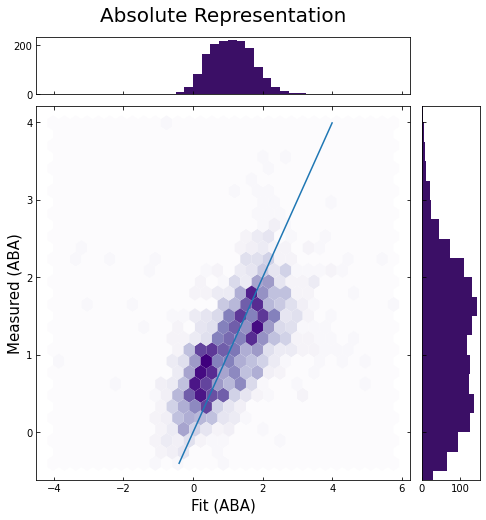

test correlation is 0.5795383055768712


In [40]:
#just to show that we aren't really over-fitting
cutoff = 3000

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(vhinge(predicted_output), y_test, title="Absolute Representation")
corr, p_value = pearsonr(vhinge(predicted_output), y_test)
print("test correlation is",corr)

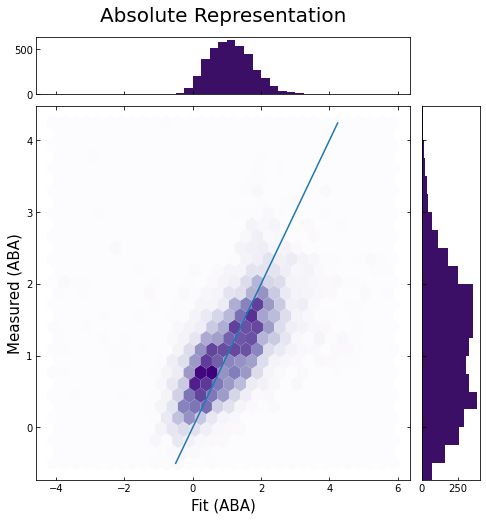

train correlation is 0.5912741960064746


In [17]:
predicted_output = reg.predict(X_train)
display(vhinge(predicted_output), y_train, title="Absolute Representation")
corr, p_value = pearsonr(vhinge(predicted_output), y_train)
print("train correlation is",corr)

In [18]:
reg.intercept_

1.1182059880362574

In [19]:
X_test

array([[-0.11525256,  0.19094065, -0.10075854, ..., -0.12095827,
        -0.12095827, -0.12188468],
       [-0.11525256,  0.19094065, -0.10075854, ..., -0.12095827,
        -0.12095827, -0.12188468],
       [-0.11525256,  0.19094065, -0.10075854, ..., -0.12095827,
        -0.12095827, -0.12188468],
       ...,
       [-0.11525256,  0.19094065, -0.10075854, ..., -0.12095827,
        -0.12095827, -0.12188468],
       [-0.11525256,  0.19094065, -0.10075854, ..., -0.12095827,
        -0.12095827,  8.20447639],
       [-0.11525256,  0.19094065, -0.10075854, ..., -0.12095827,
        -0.12095827, -0.12188468]])

In [20]:
predicted_output

array([1.37625893, 2.15318179, 1.33360342, ..., 0.52684168, 1.83521421,
       0.34509248])

In [21]:
reg.coef_

array([-0.01081276, -0.02358233,  0.06354163, -0.00700921, -0.02468931,
        0.02589349,  0.04252086, -0.05677754, -0.07220475,  0.06024284,
        0.02942588,  0.02490066,  0.00329829, -0.04207371,  0.11177699,
       -0.02984207, -0.01879767,  0.11114337,  0.14161117, -0.10456324,
       -0.02817717,  0.09406954, -0.02367609,  0.01567777, -0.12535219,
        0.10599789,  0.09748884, -0.00632095, -0.07006543,  0.14851311,
       -0.01363174,  0.04878404, -0.06570645,  0.06358117,  0.05981029,
       -0.02974555, -0.16031456,  0.12323951,  0.05592497,  0.10300317,
       -0.15226237,  0.00652104,  0.11655454, -0.01189535, -0.00598148,
       -0.04765252,  0.11806661, -0.09451522, -0.00414937,  0.01244103,
        0.09371054, -0.07851326,  0.01753571,  0.0484127 ,  0.00921755,
       -0.0395781 ,  0.05302013, -0.00694291, -0.00540547, -0.04428223,
       -0.00313473,  0.08335922, -0.05616734, -0.06200629, -0.07173997,
        0.06121067, -0.04434689, -0.01409839,  0.00599183,  0.12

In [22]:
reg.intercept_

1.1182059880362574

In [23]:
np.identity(len(X[0]))

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [24]:
singulars = reg.predict(np.identity(len(X[0])))

In [25]:
singulars-PERFECT_KD

array([-7.5100432 , -7.52281277, -7.43568881, -7.50623965, -7.52391975,
       -7.47333695, -7.45670958, -7.55600798, -7.57143519, -7.4389876 ,
       -7.46980456, -7.47432978, -7.49593215, -7.54130415, -7.38745345,
       -7.52907252, -7.51802811, -7.38808707, -7.35761927, -7.60379368,
       -7.52740761, -7.4051609 , -7.52290653, -7.48355267, -7.62458263,
       -7.39323256, -7.4017416 , -7.50555139, -7.56929587, -7.35071734,
       -7.51286218, -7.45044641, -7.56493689, -7.43564927, -7.43942015,
       -7.52897599, -7.659545  , -7.37599093, -7.44330547, -7.39622727,
       -7.65149281, -7.4927094 , -7.3826759 , -7.51112579, -7.50521192,
       -7.54688296, -7.38116383, -7.59374566, -7.50337981, -7.48678942,
       -7.40551991, -7.5777437 , -7.48169473, -7.45081774, -7.49001289,
       -7.53880854, -7.44621032, -7.50617335, -7.50463591, -7.54351268,
       -7.50236517, -7.41587123, -7.55539778, -7.56123673, -7.57097041,
       -7.43801977, -7.54357734, -7.51332883, -7.49323862, -7.37

In [26]:
#check to see if C replacement is caught
get_diff(perfect_sequence, "CCCTAGAGAGGTTATCCGCTCA")

[(2, 'replace', 'C')]

In [27]:
energies.head()

,vienna_opt,vienna_worst,vienna_mean,vienna_samples,vienna_std,vienna_skew,vienna_median,vienna_worst_100,vienna_mean_100,Sequence,sequence
0,-21.9,-16.9,-17.643825,2097,0.751334,-1.611854,-17.4,-19.200001,-19.856,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUGGAGAGGUUAUCC...,CCATGGAGAGGTTATCCTCTCA
1,-23.9,-18.9,-19.735792,1288,0.838893,-1.601279,-19.5,-21.100000,-21.820,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGAUCCGC...,CCATAGAGAGGATCCGCTCA
2,-15.5,-10.5,-11.225309,10127,0.724902,-1.580592,-11.0,-13.700000,-14.197,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAGAGGUUAUCC...,CCATAGAGAGGTTATCCGCCTACA
3,-19.5,-14.5,-15.347548,4894,0.831892,-1.490905,-15.1,-17.700001,-18.254,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUAGAUGAGGUUAUC...,CCATAGATGAGGTTATCCGCTGCA
4,-15.7,-10.7,-11.386458,4630,0.699062,-1.641765,-11.2,-13.400000,-13.914,GGGAAUGGAUCCACAUCUACGAAUUCGUACCAUACUCUCCAAUAGG...,CCATACTCTCCAATAGGGCTCA


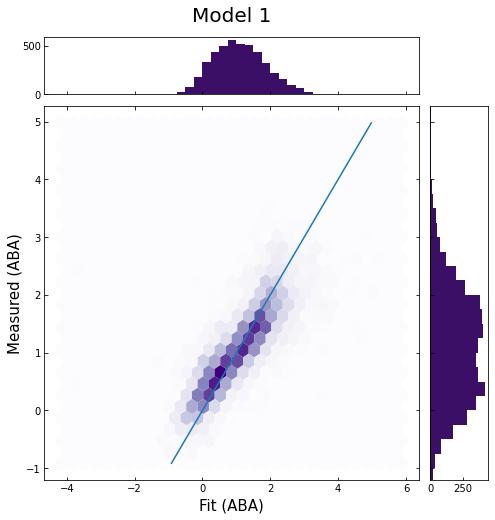

correlation is 0.7434591180881736


In [41]:
#We are using ridge regression because there are no longer outliers (we filtered them manually)

X, y = create_matrix()
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)
#This looks like the tightest regression so far
predicted_output = X @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), y, title="Model 1")
corr, p_value = pearsonr(vhinge(predicted_output), y)
print("correlation is",corr)

## Model 2
*Adding all values from vienna/mfold data*  
Due to high correlation between those values this doesn't add much predictive power to the model

In [29]:
def create_matrix2():
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                #row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])

    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

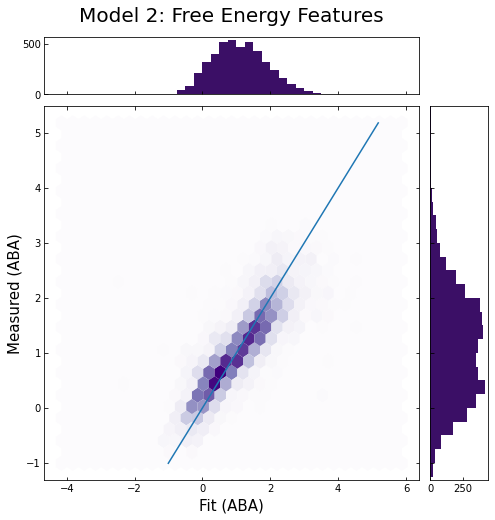

correlation is 0.7563741811866515


In [42]:
#We are using ridge regression because there are no longer outliers (we filtered them manually)

X, y = create_matrix2()
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)

predicted_output = X @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), y, title="Model 2: Free Energy Features")
corr, p_value = pearsonr(vhinge(predicted_output), y)
print("correlation is",corr)

In [43]:
X

array([[-0.12576023, -0.12484461, -0.12205908, ..., -0.12111719,
        -0.0578573 ,  0.04127377],
       [-0.12576023, -0.12484461, -0.12205908, ..., -0.12111719,
        -0.0578573 , -0.80917464],
       [-0.12576023, -0.12484461, -0.12205908, ..., -0.12111719,
        -0.0578573 ,  0.04127377],
       ...,
       [-0.12576023, -0.12484461, -0.12205908, ...,  8.256466  ,
        -0.0578573 ,  1.06181197],
       [ 7.95163954, -0.12484461, -0.12205908, ..., -0.12111719,
        -0.0578573 ,  1.68547435],
       [-0.12576023, -0.12484461, -0.12205908, ..., -0.12111719,
        -0.0578573 ,  0.43815013]])

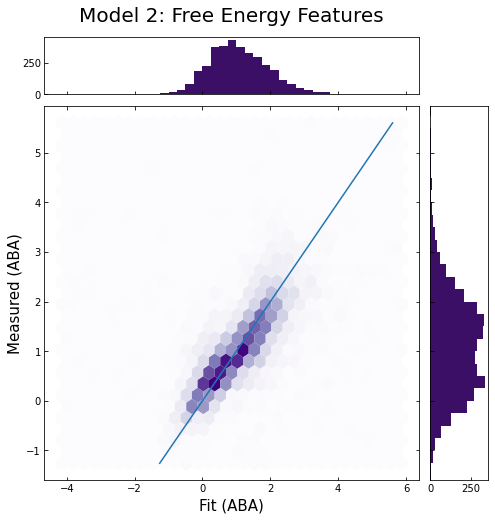

test correlation is 0.6567421576136533


In [31]:
#just to show that we aren't really over-fitting

X_train = X[:1000]
y_train = y[:1000]

X_test = X[1000:]
y_test = y[1000:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(vhinge(predicted_output), y_test, title="Model 2: Free Energy Features")
corr, p_value = pearsonr(vhinge(predicted_output), y_test)
print("test correlation is",corr)

(array([  4.,   4.,   7.,  13.,  22.,  20.,  45.,  63., 121., 108., 140.,
        200., 201., 210., 235., 252., 221., 197., 192., 180., 162., 153.,
        148., 101., 113.,  83.,  68.,  54.,  40.,  33.,  21.,  27.,  13.,
         13.,  10.,   6.,   7.,   2.,   1.,   1.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   1.,   1.,   1.]),
 array([-1.260212  , -1.12293942, -0.98566684, -0.84839425, -0.71112167,
        -0.57384909, -0.4365765 , -0.29930392, -0.16203134, -0.02475875,
         0.11251383,  0.24978641,  0.387059  ,  0.52433158,  0.66160416,
         0.79887675,  0.93614933,  1.07342191,  1.2106945 ,  1.34796708,
         1.48523966,  1.62251225,  1.75978483,  1.89705741,  2.03433   ,
         2.17160258,  2.30887516,  2.44614775,  2.58342033,  2.72069291,
         2.8579655 ,  2.99523808,  3.13251066,  3.26978325,  3.40705583,
         3.54432841,  3.681601  ,  3.81887358,  3.95614616,  4.09341874,
         4.23069133,  4.36796391,  4.50523649,  4.64250908,  4.77978166,
 

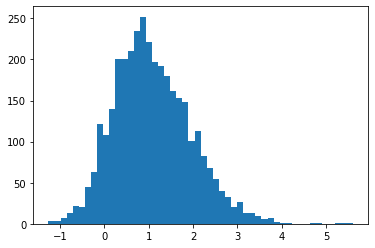

In [32]:
plt.hist(vhinge(predicted_output), bins=50)

(array([  4.,   3.,   1.,   2.,   2.,   0.,   0.,   0.,   1.,   4.,   1.,
          1.,   2.,   1.,   2.,  16.,  24.,  50.,  82., 145., 206., 214.,
        269., 243., 216., 208., 248., 256., 265., 250., 201., 166., 127.,
         78.,  62.,  38.,  25.,  25.,  15.,  10.,   6.,   4.,   7.,   3.,
          3.,   4.,   0.,   1.,   1.,   4.]),
 array([-4.15550752, -3.95485891, -3.7542103 , -3.55356169, -3.35291308,
        -3.15226447, -2.95161585, -2.75096724, -2.55031863, -2.34967002,
        -2.14902141, -1.9483728 , -1.74772419, -1.54707557, -1.34642696,
        -1.14577835, -0.94512974, -0.74448113, -0.54383252, -0.34318391,
        -0.1425353 ,  0.05811332,  0.25876193,  0.45941054,  0.66005915,
         0.86070776,  1.06135637,  1.26200498,  1.46265359,  1.66330221,
         1.86395082,  2.06459943,  2.26524804,  2.46589665,  2.66654526,
         2.86719387,  3.06784249,  3.2684911 ,  3.46913971,  3.66978832,
         3.87043693,  4.07108554,  4.27173415,  4.47238276,  4.67303138,
 

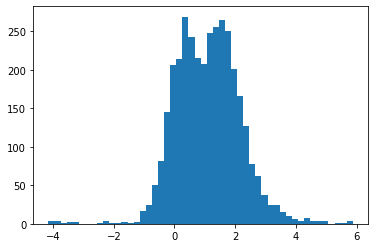

In [33]:
plt.hist(y_test, bins=50)

## Model 3
*Adding pooling values*  
The idea behind this model is that (if position is the most important factor) pooling our data should enhance the dataset and also be a good model on its own even though there are substantially less variables

In [34]:
# the start of this function is same as before
def create_matrix3():
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        #adding pooling for each position
        for gene in range(int(len(X[0])/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int(len(X[0])/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        #adding pooling for group of six nucleutide positions
        for gene in range(int(len(X[0])/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int(len(X[0])/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
            #add_row.extend([max(sub_list)**2, min(sub_list)**2,sum(sub_list)**2])
        X_add.append(add_row)
    X_add = np.array(X_add)
    
    
    X = np.append(X, X_add, axis=1)
    
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

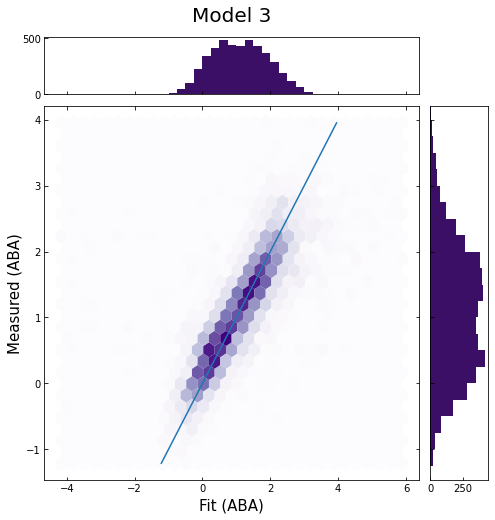

correlation is 0.7796709754519018


In [35]:
#We are using ridge regression because there are no longer outliers (we filtered them manually)

X, y = create_matrix3()
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)
#This looks like the tightest regression so far
predicted_output = X @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), y, title="Model 3")
corr, p_value = pearsonr(vhinge(predicted_output), y)
print("correlation is",corr)

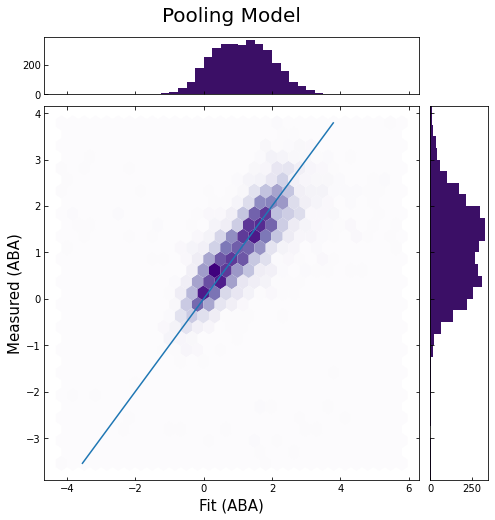

test correlation is 0.6599791414852582


In [37]:
#just to show that we aren't really over-fitting

X_train = X[:1000]
y_train = y[:1000]

X_test = X[1000:]
y_test = y[1000:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
predicted_output = X_test @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), y_test, "Pooling Model")
corr, p_value = pearsonr(vhinge(predicted_output), y_test)
print("test correlation is",corr)

**A quick look at how the different coefficients are weighted**  
I'm not really sure what to make of it

In [37]:
def hist_plot(arr):
    print([int(elt/9) for elt in range(len(arr))])
    print([get_action(elt) for elt in range(len(arr))])
    print(arr)
    df = pd.DataFrame({"Position": [int(elt/9) for elt in range(len(arr))],
                        "Action": [get_action(elt) for elt in range(len(arr))],
                            "Val": arr})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white", figsize=(20,10))
    plt.xticks(rotation = 0)
    # horizontal line indicating the threshold
    plt.plot([-0.5, 22], [0, 0], "k--")
    plt.show()

In [54]:
X, y = create_matrix()
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [55]:
singulars = reg.predict(np.identity(len(X[0])))
arr = singulars#-reg.intercept_

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21]
['INS A', 'INS C', 'INS G', 'INS T', 'REP A', 'REP C', 'REP G', 'REP T', 'DEL', 'INS A', 'INS C', 'INS G', 'INS T', 'REP A', 'REP C', 'REP G', 'REP T', 'DEL', 'INS A', 'INS C', 'INS G', 'INS T', 'REP A', 'REP C', 'REP G', 'REP T', 'DEL', 'INS A', 'INS C', 'INS G', 'INS T', 'REP A', 'REP C', 'REP 

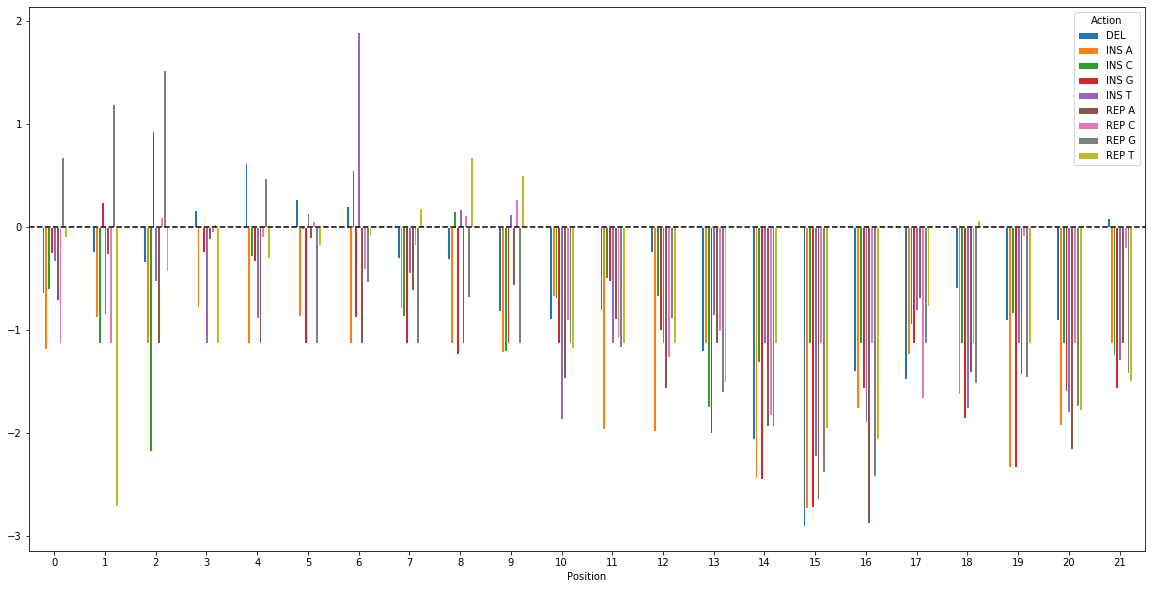

In [56]:
hist_plot(singulars-PERFECT_KD)

In [57]:
def hist_plot_insertions(arr):
    df = pd.DataFrame({"Position": [int(elt/9) for elt in range(len(arr)) if elt % 9 in (0,1,2,3)],
                        "Action": [get_action(elt) for elt in range(len(arr)) if elt % 9 in (0,1,2,3)],
                            "Val": [arr[i] for i in range(len(arr)) if i % 9 in (0,1,2,3)]})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white", figsize=(20,10))
    plt.xticks(ticks = np.arange(22),labels = list(range(1,23))[::-1],rotation = 0)
    # horizontal line indicating the threshold
    plt.plot([-0.5, 22], [0, 0], "k--")
    #plt.plot([-0.5, 22], [-reg.intercept_, -reg.intercept_], "k--")
    plt.ylabel("Normalized Linear Feature Weights", fontsize=24)
    plt.xlabel("Position", fontsize=24)
    plt.title("Weights for the Insertion Position Features", fontsize=30)
    plt.show()
def hist_plot_insertions_avg(arr):
    sub_arr = [arr[elt] for elt in range(len(arr)) if elt % 9 in (0,1,2,3)]
    #print(len(sub_arr))
    avged = np.mean(np.array(sub_arr).reshape(-1, 4), axis=1)
    df = pd.DataFrame({"Position": [int(elt/4) for elt in range(len(sub_arr)) if elt%4 == 0],
                        "Action": ["Position" for elt in range(len(sub_arr)) if elt%4 == 0],
                            "Val": avged})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white",
                                                                              figsize=(20,10), legend=None)
    plt.xticks(ticks = np.arange(22),labels = list(range(1,23))[::-1],rotation = 0)
    # horizontal line indicating the threshold
    plt.plot([-0.5, 22], [0, 0], "k--")
    #plt.plot([-0.5, 22], [-reg.intercept_, -reg.intercept_], "k--")
    plt.ylabel("Normalized Linear Feature Weights", fontsize=24)
    plt.xlabel("Position", fontsize=24)
    plt.title("Average Weights for Insertion Position Features", fontsize=30)
    plt.show()

In [58]:
def hist_plot_replacements(arr):
    df = pd.DataFrame({"Position": [int(elt/9) for elt in range(len(arr)) if elt % 9 in (4,5,6,7)],
                        "Action": [get_action(elt) for elt in range(len(arr)) if elt % 9 in (4,5,6,7)],
                            "Val": [arr[i] for i in range(len(arr)) if i % 9 in (4,5,6,7)]})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white", figsize=(20,10))
    plt.xticks(ticks = np.arange(22),labels = list(range(1,23))[::-1],rotation = 0)
    #plt.set_axis_direction("left")
    # horizontal line indicating the threshold
    plt.plot([-0.5, 22], [0, 0], "k--")
    #plt.plot([-0.5, 22], [-reg.intercept_, -reg.intercept_], "k--")
    plt.ylabel("Normalized Linear Feature Weights", fontsize=24)
    plt.xlabel("Position", fontsize=24)
    plt.title("Weights for the Substitution Position Features", fontsize=30)
    plt.show()
def hist_plot_replacements_avg(arr):
    sub_arr = [arr[elt] for elt in range(len(arr)) if elt % 9 in (4,5,6,7)]
    #print(arr)
    #print(sub_arr)
    #print(len(arr))
    #print(len(sub_arr))
    avged = np.mean(np.array(sub_arr).reshape(-1, 4), axis=1)
    df = pd.DataFrame({"Position": [int(elt/4) for elt in range(len(sub_arr)) if elt%4 == 0],
                        "Action": ["Position" for elt in range(len(sub_arr)) if elt%4 == 0],
                            "Val": avged})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white",
                                                                              figsize=(20,10), legend=None)
    plt.xticks(ticks = np.arange(22),labels = list(range(1,23))[::-1],rotation = 0)
    # horizontal line indicating the threshold
    plt.plot([-0.5, 22], [0, 0], "k--")
    #plt.plot([-0.5, 22], [-reg.intercept_, -reg.intercept_], "k--")
    plt.ylabel("Normalized Linear Feature Weights", fontsize=24)
    plt.xlabel("Position", fontsize=24)
    plt.title("Average Weights for Substitution Position Features", fontsize=30)
    plt.show()

In [59]:
reg.intercept_

1.5981907104177724

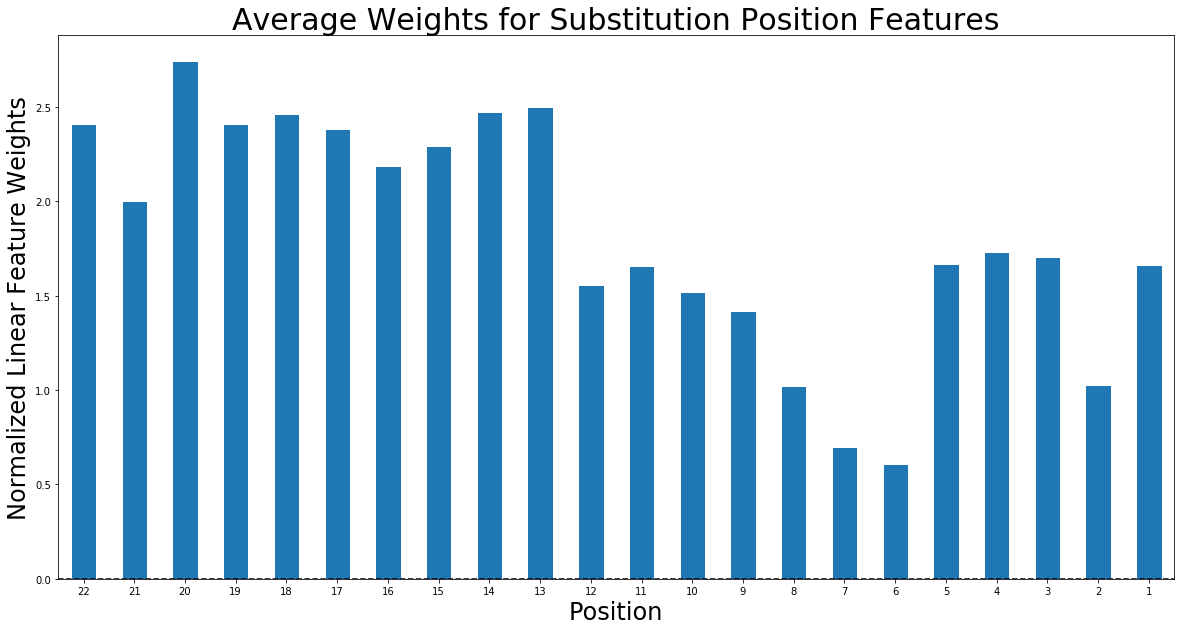

In [60]:
hist_plot_replacements_avg(arr)

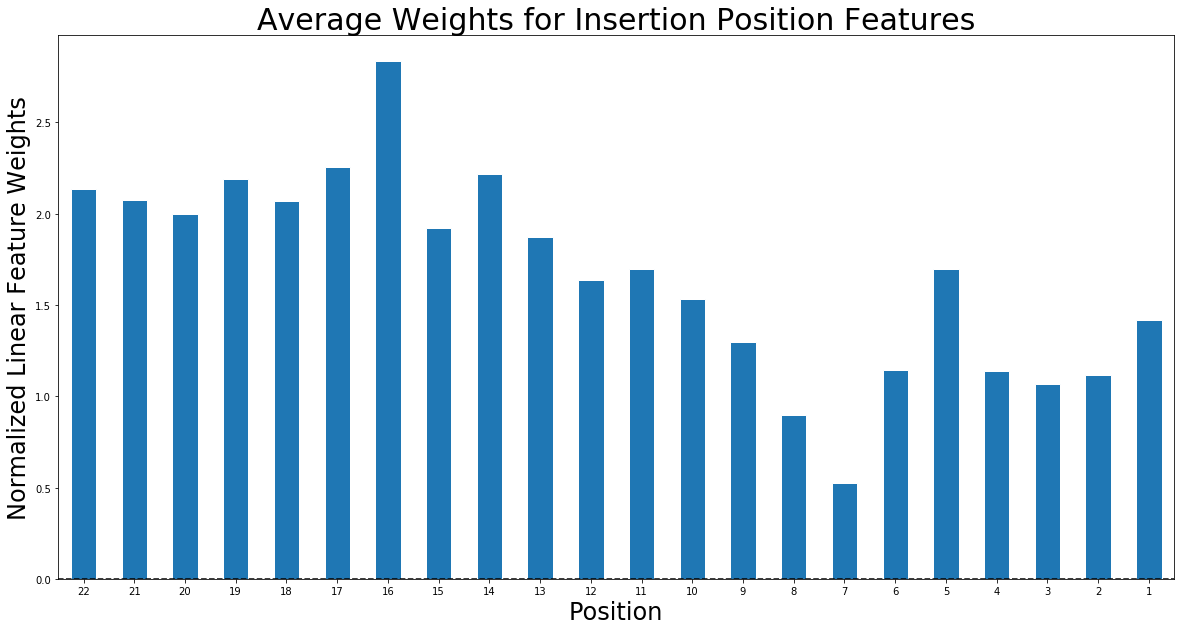

In [61]:
hist_plot_insertions_avg(arr)

In [62]:
def hist_plot_deletions(arr):
    df = pd.DataFrame({"Position": [int(elt/9) for elt in range(len(arr)) if elt % 9 in (8,)],
                        "Action": [get_action(elt) for elt in range(len(arr)) if elt % 9 in (8,)],
                            "Val": [arr[i] for i in range(len(arr)) if i % 9 in (8,)]})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white",
                                                                              figsize=(20,10),fontsize=15, legend=None)
    plt.xticks(ticks = np.arange(22),labels = list(range(1,23))[::-1],rotation = 0)
    # horizontal line indicating the threshold
    plt.plot([-0.5, 22], [0, 0], "k--")
    #plt.plot([-0.5, 22], [-reg.intercept_, -reg.intercept_], "k--")
    plt.ylabel("Normalized Linear Feature Weights", fontsize=24)
    plt.xlabel("Position", fontsize=24)
    plt.title("Weights for the Deletion Position Features", fontsize=30)
    plt.show()

In [63]:
def hist_plot_avg(arr):
    avged = np.mean(np.array(arr).reshape(-1, 9), axis=1)
    df = pd.DataFrame({"Position": [int(elt/9) for elt in range(len(arr)) if elt % 9 in (8,)],
                        "Action": ["Position" for elt in range(len(arr)) if elt % 9 in (8,)],
                            "Val": avged})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white",
                                                                              figsize=(20,10),fontsize=15, legend=None)
    plt.xticks(ticks = np.arange(22),labels = list(range(1,23))[::-1],rotation = 0)
    # horizontal line indicating the threshold
    plt.plot([-0.5, 22], [0, 0], "k--")
    #plt.plot([-0.5, 22], [-reg.intercept_, -reg.intercept_], "k--")
    plt.ylabel("Normalized Linear Feature Weights", fontsize=24)
    plt.xlabel("Position", fontsize=24)
    plt.title("Average Weights for the Position Features", fontsize=30)
    #plt.get_legend().remove()
    plt.show()

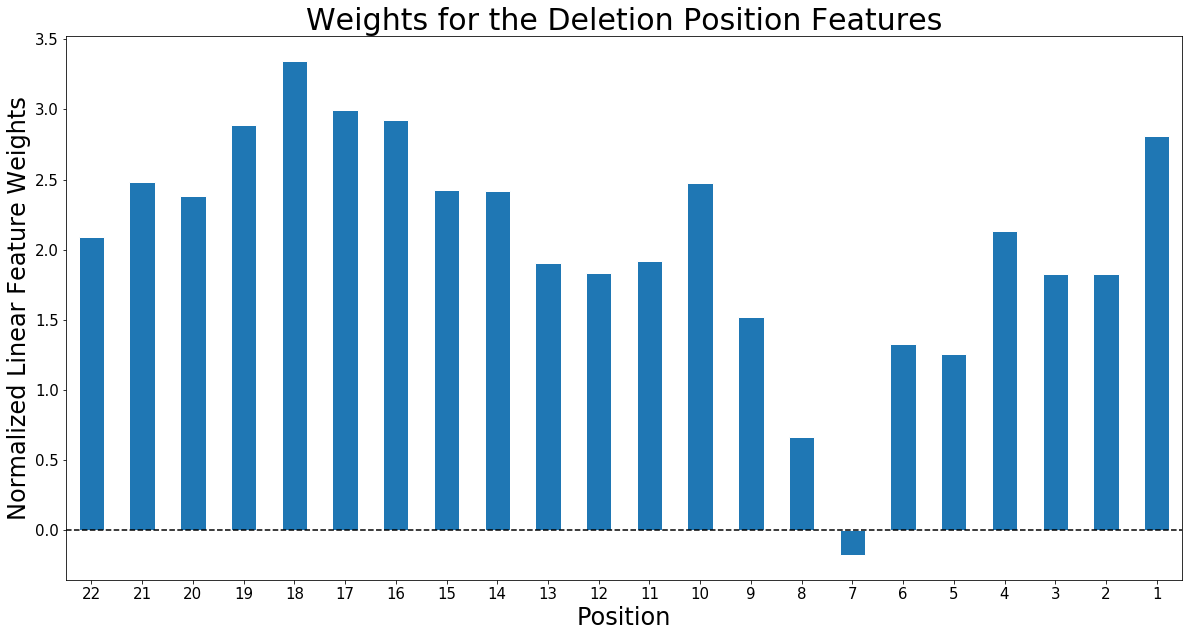

In [64]:
hist_plot_deletions(arr)

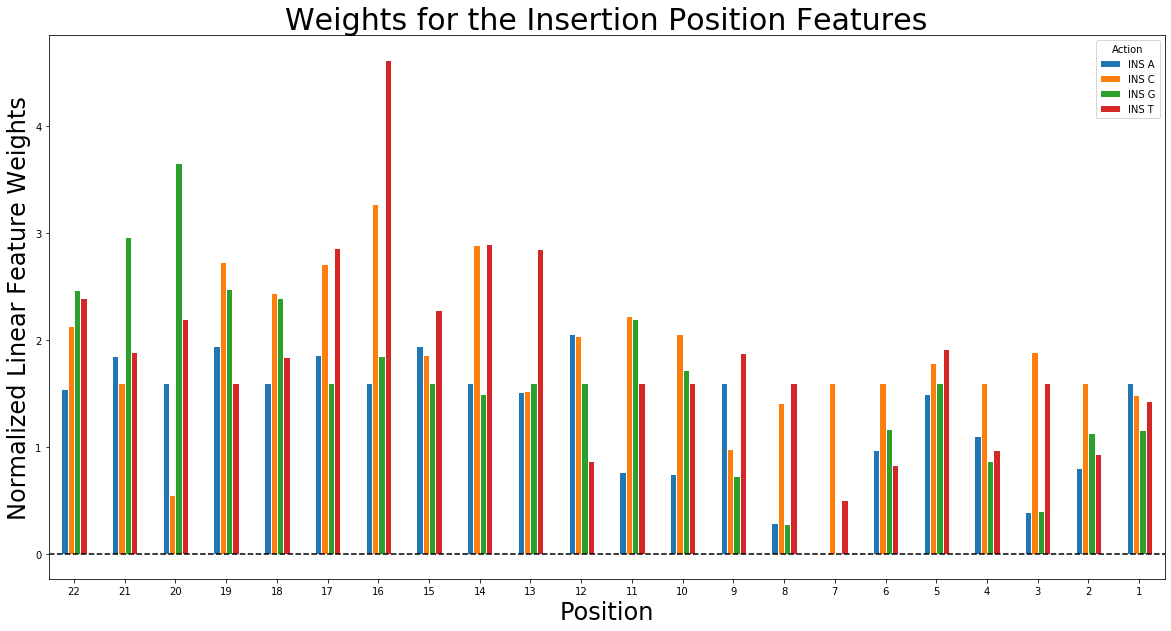

In [65]:
hist_plot_insertions(arr)

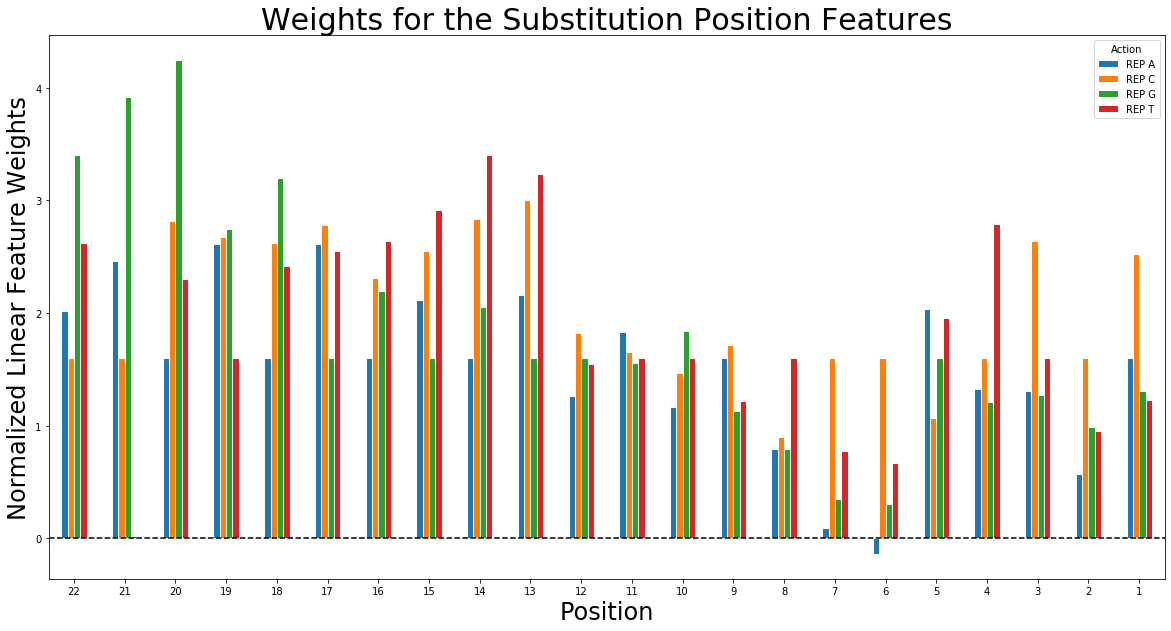

In [66]:
hist_plot_replacements(arr)

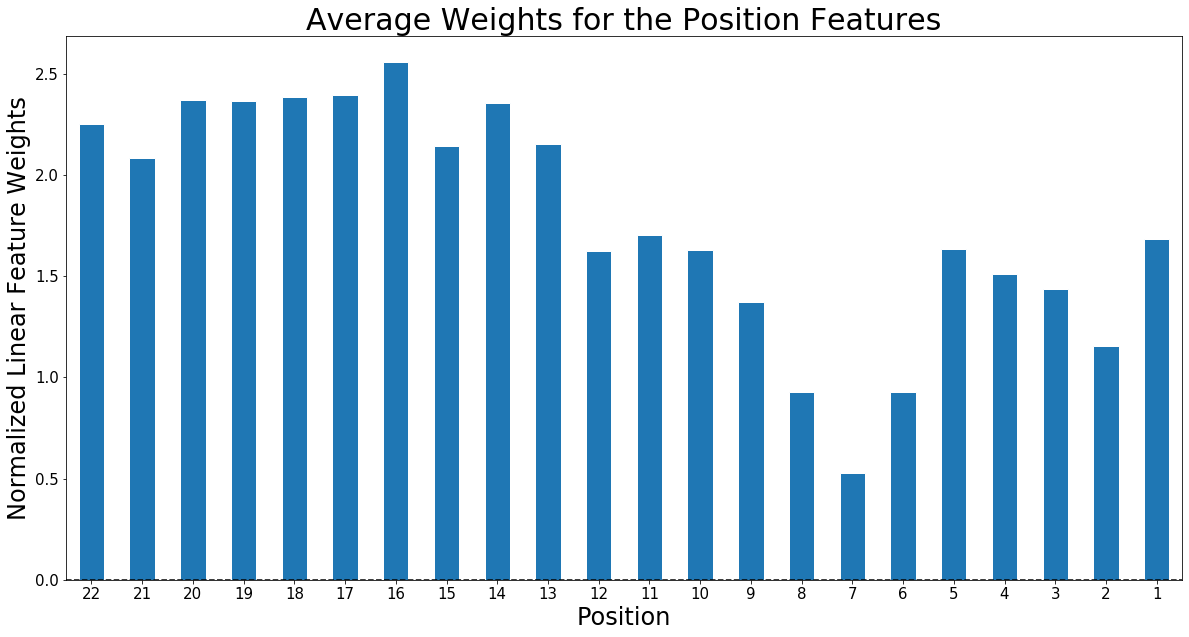

In [67]:
hist_plot_avg(arr)

**Lets look at how the added features perform on their own**

In [32]:
# the start of this function is same as before
def create_matrix3point5():
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                #row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        #adding pooling for each position
        for gene in range(int(len(X[0])/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int(len(X[0])/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        
        #adding pooling for group of six nucleutide positions
        for gene in range(int(len(X[0])/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int(len(X[0])/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
            #add_row.extend([max(sub_list)**2, min(sub_list)**2,sum(sub_list)**2])
        X_add.append(add_row)
    X_add = np.array(X_add)
    
    ################THIS IS THE ONLY CHANGED LINE FROM ABOVE#######################
    X = X_add
    
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

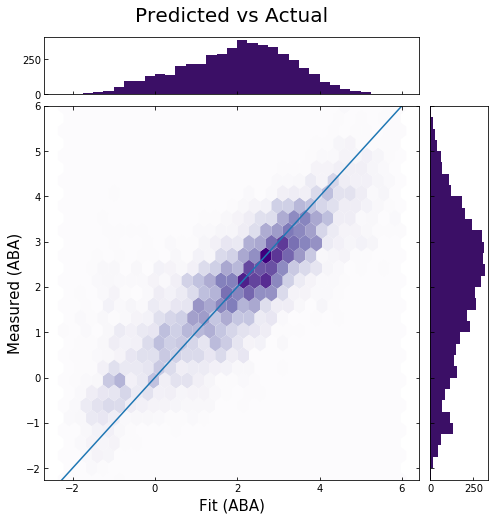

correlation is 0.8310787755285732


In [33]:
#We are using ridge regression because there are no longer outliers (we filtered them manually)

X, y = create_matrix3point5()
reg = linear_model.Ridge(alpha=1)
reg.fit(X, y)
#This looks like the tightest regression so far
predicted_output = X @ reg.coef_ + reg.intercept_
display(vhinge(predicted_output), y)
corr, p_value = pearsonr(vhinge(predicted_output), y)
print("correlation is",corr)

In [35]:
len(X[0])

129

## Model 4
*Convolution Neural Network Model (CNN)*
As you can see from above, pooling (without even using the energy values we calculated) still has a pretty high r value. The process we used on our data resembles a very primitive CNN with a pooling and simple linear activation. We now try to see if we can actually create a net that has high training and test accuracy

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
# the start of this function is same as before
def create_matrix4():
    max_len = 0
    for seq in seq_aba_pairs:
        max_len = max(max_len, len(seq))
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq)
            row = [0 for i in range(9*len(perfect_sequence))]
            if len(coords) > 5:
                pass
            else:
                for coord in coords:
                    row[get_position(coord)] = 1
                #append the value of the energy levels
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['vienna_worst_100'])
                #row.extend(list(big_table[big_table['sequence'] == seq].iloc[0][cols]))
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    
    #these are pooling values
    X_add = []
    for row in X:
        add_row = []
        #adding pooling for each position
        for gene in range(int(len(X[0])/9)):
            add_row.extend([max(row[gene*9: (gene+1)*9]), min(row[gene*9: (gene+1)*9]),
                           sum(row[gene*9: (gene+1)*9])])
        #adding pooling for group of three nucleutide positions
        for gene in range(int(len(X[0])/27)):
            add_row.extend([max(row[gene*27: (gene+1)*27]), min(row[gene*27: (gene+1)*27]),
                           sum(row[gene*27: (gene+1)*27])])
        #adding pooling for group of six nucleutide positions
        for gene in range(int(len(X[0])/54)):
            add_row.extend([max(row[gene*54: (gene+1)*54]), min(row[gene*54: (gene+1)*54]),
                           sum(row[gene*54: (gene+1)*54])])
        for gene in range(int(len(X[0])/108)):
            add_row.extend([max(row[gene*99: (gene+1)*99]), min(row[gene*99: (gene+1)*99]),
                           sum(row[gene*99: (gene+1)*99])])
        for i in range(9):
            sub_list = [row[gene*9: (gene+1)*9][i] for gene in range(int(len(X[0])/9))]
            add_row.extend([max(sub_list), min(sub_list),sum(sub_list)])
        row = [0 for i in range(4*max_len)]
        for i in range(len(seq)):
            if seq[i] == 'A':
                row[i*4 + 0] = 1
            elif seq[i] == 'C':
                row[i*4 + 1] = 1
            elif seq[i] == 'G':
                row[i*4 + 2] = 1
            elif seq[i] == 'T':
                row[i*4 + 3] = 1
            else:
                print("Impossible happened check seq values", seq)
        add_row.extend(row)
        X_add.append(add_row)
    X_add = np.array(X_add)
    
    
    X = np.append(X, X_add, axis=1)
    #X = np.append(X, create_matrix_0(randomize=False)[0], axis=1)
    
    #scaling for later
    X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

In [43]:
#make sure to install keras if you don't have the package yet
from keras import layers, models

In [44]:
#returns a CNN model given training data
def train(X, y, batch_size=100, epochs=100):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    y_ = y.reshape(len(y), 1)
    print("input shaped", (len(X[0]), 1, 1))
    
    model = models.Sequential()
    #model.add(layers.Conv2D(16, (3, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    #model.add(layers.MaxPooling2D((3, 1)))
    #model.add(layers.Conv2D(32, (9, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    #model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Conv2D(64, (54, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1, activation='linear'))
    model.summary()
    
    

    #model.compile(loss='mean_squared_error',
    #              optimizer='sgd')
    model.compile(loss='logcosh',
                  optimizer='sgd')
    model.fit(X_, y_,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1
              )
    return model

#fits the data based on the trained model from above
def fit(model, X, y):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    display(vhinge(model.predict(X_)).reshape(len(X_)), y)
    
    corr, p_value = pearsonr(vhinge((model.predict(X_)).reshape(len(X_))), y)
    print("corr is", corr)
    #return vhinge((model.predict(X_)).reshape(len(X_))), y
    
# no longer necessary  
def without_outliers(model, X, y):
    outliers = []
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    predictions = vhinge((model.predict(X_)).reshape(len(X_)))
    for i in range(len(predictions)):
        if predictions[i]-y[i] > 3:
            print("removing", predictions[i], y[i])
            predictions = np.delete(predictions, i)
            y.pop(i)

In [53]:
X, y = create_matrix4()

input shaped (439, 1, 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 386, 1, 64)        3520      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 1, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                524352    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 527,937
Trainable params: 527,937
Non-trainable params: 0
_________________________________________________________________

Epoch 1/100
4000/4000 [==============================] - 1s 327us/step - loss: 0.5527
E

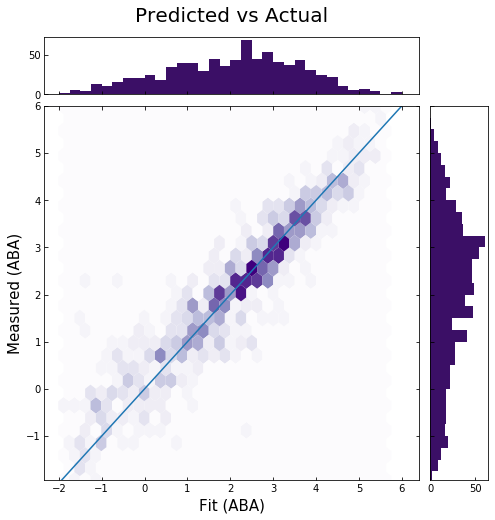

corr is 0.9319014116632276


In [45]:
#this will take 5 minutes to run
X_train = X[:4000]
X_test = X[4000:]

y_train = y[:4000]
y_test = y[4000:]

model = train(X_train, y_train, epochs=100)
fit(model, X_test, y_test)

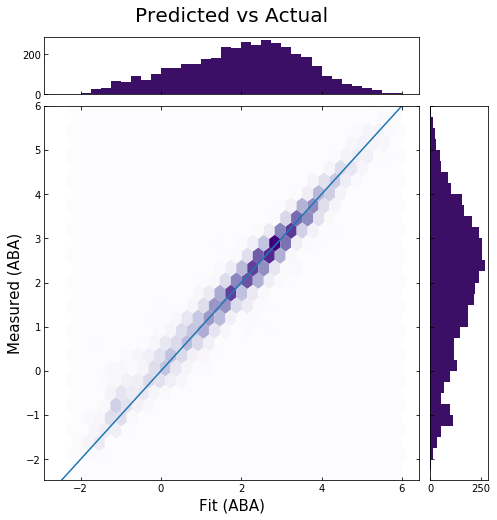

corr is 0.9759359434131396


In [46]:
fit(model, X_train, y_train)

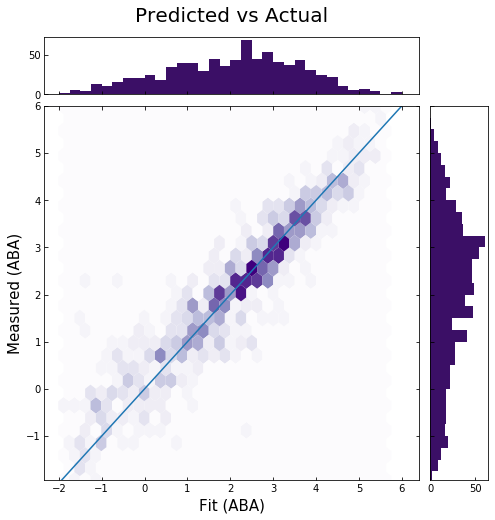

corr is 0.9319014116632276


In [47]:
fit(model, X_test, y_test)

In [19]:
def fit_v_meas_plot(x, loc_data, pamlen, del_trunc=1, model_func=None):
    width_ratios = [1, 6, 1]
    height_ratios = [1, 6, 1]
    gs = mpl.gridspec.GridSpec(3, 3, width_ratios=width_ratios, height_ratios=height_ratios, 
                               wspace=0.1, hspace=0.1,
                               bottom=0.0, top=1.0, left=0.0, right=1.0)
    fig = plt.figure(figsize=(sum(width_ratios), sum(height_ratios)))

    all_meas, all_fit = get_all_meas_and_fit(x, loc_data, pamlen, del_trunc, model_func)
    zbl, ztr, zxr, zxl, zyb, zyt, new_x, new_y, not_corner_x, not_corner_y = split_data(all_meas, all_fit)
    r, pval = pearsonr(all_meas, all_fit)
    center_r, _ = pearsonr(new_x, new_y)
    not_corner_r, _ = pearsonr(not_corner_x, not_corner_y)
    lim = (log10_lb - 1, log10_ub + 1)

    # Corners
    ax = plt.subplot(gs[2])
    ax.text(0, 0, '$(ub, ub)$\n$%.0f$%%' % (100*float(ztr)/len(all_meas)), 
            fontsize=16, ha='center', va='center')
    ax = plt.subplot(gs[6])
    ax.text(0, 0, '$(lb, lb)$\n$%.0f$%%' % (100*float(zbl)/len(all_meas)), 
            fontsize=16, ha='center', va='center')
    for idx in [0, 2, 6, 8]:
        ax = plt.subplot(gs[idx])
        ax.set_xticks([]); ax.set_yticks([])
        ax.axis('off')
        ax.set_xlim((-0.5, 0.2))
        ax.set_ylim((-0.5, 0.2))
    

    # Correlation Plot
    ax = plt.subplot(gs[4])
    #ax.hexbin(new_x, new_y, gridsize=30, cmap='Greys', mincnt=1, vmin=0, vmax=0.005*len(new_x))
    ax.scatter(new_x, new_y, c=density_color(new_x, new_y), cmap='viridis', edgecolors='none')
    #ax.scatter(all_meas, all_fit, c=density_color(all_meas, all_fit), cmap='viridis', edgecolors='none')
    ax.text((lim[0] + lim[1])/2, (11*lim[0] + lim[1])/12, '$r = %.2f,\ r_c = %.2f,\ r_{nc} = %.2f$' % (r, center_r, not_corner_r), 
            fontsize=18, ha='center', va='center')
    ax.set_aspect(1)
    ax.legend(loc='lower right')

    ax.plot(lim, lim, 'k--', alpha=0.5)
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    # hist stuff
    max_pct = 20
    h = float(max_pct)/100 * len(all_meas)
    loc_frac = 0.85
    nbins = 30
    text_pos = log10_lb + 1*data_span
    
    # XL hist
    ax = plt.subplot(gs[3])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zxl, bins, histtype='step', orientation='horizontal', color='grey')
    ax.set_xlim((h, 0))
    ax.set_xticklabels([]); 
    ax.set_xticks((0, h))
    ax.set_xticklabels((0, '{}%'.format(max_pct)))
    #ax.set_xlabel('$(0, y)$')
    ax.set_ylim(lim)
    ax.text(h/2, text_pos, '$(lb, y)$\n$%.0f$%%' % (100*float(len(zxl))/len(all_meas)), 
            fontsize=16, ha='center', va='center')
    ax.set_ylabel('Fit log10 Cleavage Rate ($s^{-1}$)')
    
    # XR hist
    ax = plt.subplot(gs[5])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zxr, bins, histtype='step', orientation='horizontal', color='grey')
    ax.set_xlim((0, h))
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_xticks((0, h))
    ax.set_xticklabels((0, '{}%'.format(max_pct)))
    #ax.set_xlabel('$(0, y)$')
    ax.set_ylim(lim)
    ax.text(h/2, text_pos, '$(ub, y)$\n$%.0f$%%' % (100*float(len(zxr))/len(all_meas)), 
            fontsize=16, ha='center', va='center')
    
    # YB hist
    ax = plt.subplot(gs[7])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zyb, bins, histtype='step', color='grey')
    ax.set_ylim((h, 0))
    ax.set_yticks((0, h))
    ax.set_yticklabels([])
    ax.set_yticklabels((0, '{}%'.format(max_pct)))
    #ax.set_ylabel('$(x, 0)$')
    ax.set_xlim(lim)
    ax.text(text_pos, h/2, '$(x, lb)$\n$%.0f$%%' % (100*float(len(zyb))/len(all_meas)), 
            fontsize=16, ha='center', va='center')
    ax.set_xlabel('Measured log10 Cleavage Rate ($s^{-1}$)')

    # YT hist
    ax = plt.subplot(gs[1])
    bins = np.linspace(lim[0], lim[1], nbins)
    ax.hist(zyt, bins, histtype='step', color='grey')
    ax.set_ylim((0, h))
    ax.set_yticks((0, h))
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_yticklabels((0, '{}%'.format(max_pct)))
    #ax.set_ylabel('$(x, 0)$')
    ax.set_xlim(lim)
    ax.text(text_pos, h/2, '$(x, ub)$\n$%.0f$%%' % (100*float(len(zyt))/len(all_meas)), 
            fontsize=16, ha='center', va='center')

    print_minus_zeros_r(all_meas, all_fit)
    return fig, ax

NameError: name 'single_effects' is not defined

In [130]:
# to help analyze results
import matplotlib as mpl
def display1(predicted, actual):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, gridsize=(30,15),  cmap='Purples', edgecolors='none' )
    ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
                                                x, 1))(np.unique(y)))

    ax_scatter.set_xlabel("Fit (ABA)", fontsize=15)
    ax_scatter.set_ylabel("Measured (ABA)", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    #ax_scatter.set_xlim((-lim, lim))
    #ax_scatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title('Predicted vs Measured ABA',pad=15, fontsize=20)
    ax_histy.hist(y, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())
    

    plt.show()
    
    

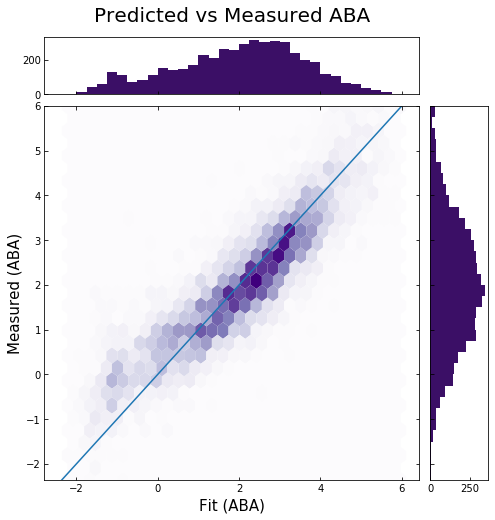

In [131]:
display1(vhinge(predicted_output), y)

In [616]:
#Plots detailed results
def display1(predicted, actual, title="Predicted vs Actual"):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    #ax_histx = plt.axes(rect_histx)
    #ax_histx.tick_params(direction='in', labelbottom=False)
    #ax_histy = plt.axes(rect_histy)
    #ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, gridsize=(30,15),  cmap='Purples', edgecolors='none' )
    #ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
    #                                            x, 1))(np.unique(y)))

    ax_scatter.set_xlabel("Free Energy (kcal/mol)", fontsize=15)
    ax_scatter.set_ylabel("Measured (ABA)", fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    plt.title(title, fontsize=20)
    #ax_scatter.set_xlim((-lim, lim))
    #ax_scatter.set_ylim((-lim, lim))

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    #ax_histx.hist(x, bins=bins,  color=(0.23, 0.06, 0.4))
    #ax_histx.set_title(title,pad=15, fontsize=20)
    #ax_histy.hist(y, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    #ax_histx.set_xlim(ax_scatter.get_xlim())
    #ax_histy.set_ylim(ax_scatter.get_ylim())
    

    plt.show()

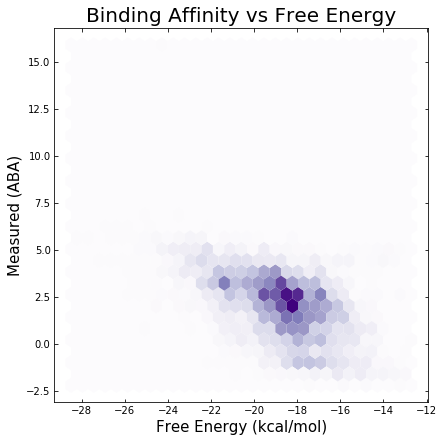

In [617]:
#display1(big_table.vienna_opt,big_table.ABA,"Hi")
display1(big_table.ABA,big_table.vienna_opt,title="Binding Affinity vs Free Energy")

In [428]:
corr, p_value = pearsonr(big_table.vienna_opt, big_table.ABA)

In [429]:
corr

-0.5257564276433702

In [7]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

regr = OLS(y, add_constant(X)).fit()
print(regr.aic)

11929.188810248968


In [17]:
X, y = create_matrix4()

NameError: name 'create_matrix4' is not defined

In [54]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

regr = OLS(y, add_constant(X)).fit()
print(regr.aic)

9552.611397937619


In [ ]:
#full model with pooling is 9498.39
#model with free energy is 10671.60
#original model aic is 11929.18
#pooling model aic is 12683.97
#absolute model aic is 15050.81

"\nfig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)\naxs[0].bar(names, values)\naxs[1].scatter(names, values)\naxs[2].plot(names, values)\nfig.suptitle('Categorical Plotting')\n"

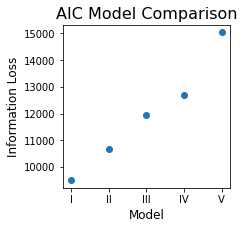

In [68]:
import matplotlib.pyplot as plt

data = {'I': 9498.39, 'II': 10671.60, 'III': 11929.18, 'IV': 12683.97, "V": 15050.81}
names = list(data.keys())
values = list(data.values())
plt.figure(figsize=(3, 3))
plt.ylabel("Information Loss", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.title("AIC Model Comparison", fontsize=16)
plt.scatter(names,values)
"""
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].bar(names, values)
axs[1].scatter(names, values)
axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')
"""

In [ ]:
axs[1].scatter(names, values)